In [1]:
import numpy as np
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})

import scipy.linalg as spl
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
import xarray as xr

from waveeqn1D import WaveEquation

# Simple, 2-layer internal waves in 1D with variable speed

## Setting up the problem

$\dfrac{\partial^2 \eta}{\partial t^2} = \dfrac{\partial}{\partial x} \left(c^2 \dfrac{\partial  \eta}{\partial x} \right)$, where $c^2 = \dfrac{g'}{\frac{1}{H_1}+\frac{1}{H_2}}$ and $g' = g\dfrac{\rho_2-\rho_1}{\rho_1}$

In [2]:
# Dummy class to hold all the problem parameters
class Param:
    def init(self):
        pass
param = Param()
param.Htop = 200     # Thickness of the top layer
param.Hbot = 2000
param.rhotop = 997
param.rhobot = 1001
param.g = 9.81

paramSeafloor = Param()
paramSeafloor.K = 30e9 #bulk modulus Pa
paramSeafloor.mu = 30e9  #shear modulus Pa
paramSeafloor.nu = (3*paramSeafloor.K-2*paramSeafloor.mu)/2/(3*paramSeafloor.K+paramSeafloor.mu) # Poisson's ratio
paramSeafloor.E = 9*paramSeafloor.K*paramSeafloor.mu/(3*paramSeafloor.K+paramSeafloor.mu)#Young's modulus

In [3]:
def gwspeed(param):
    """Compute the gravity wave speed for a 2-layer shallow-water model
    Args:
     - param, object whose attributes are various parameters of the model (g,rhobot,rhotop,Hbot,Htop) in SI units
    Returns:
     - c, gravity wave speed in m/s
    """
    return np.sqrt(param.g*(param.rhobot/param.rhotop-1)/(1/param.Htop+1/param.Hbot))

def pressure_to_zeta(p,paramSeafloor):
    """From a pressure anomaly applied on the seafloor, return the corresponding vertical displacement.
    Assumed the pressure is distributed over a circle of radius 500m
    Args:
     - p, pressure anomaly in Pa
     - param, object whose attributes contain the Poisson ratio (nu) & Young modulus (E) of the seafloor
    Returns:
     - zeta, vertical displacement in m
    """
    r = 5e2 #Radius over which pressure is applied , in m
    return -(1-paramSeafloor.nu**2)*np.pi*r*p/(4*paramSeafloor.E)

def plot_triangle(ax,x,y,size,stretch=1,**kwargs):
    x0 = x-size/2; x1 = x+size/2
    y0 = y+size*2/np.sqrt(3)*stretch
    ax.plot([x0,x1],[y0,y0],transform=ax.transAxes,linewidth=3,**kwargs)
    ax.plot([x0,x],[y0,y]  ,transform=ax.transAxes,linewidth=3,**kwargs)
    ax.plot([x1,x],[y0,y]  ,transform=ax.transAxes,linewidth=3,**kwargs)

In [4]:
def modulation(x,x0=10e3,halfwidth=1e3):
    """Function to scale velocity variations in the 1D domain.
    Args:
     - p, pressure anomaly in Pa
     - param, object whose attributes contain the Poisson ratio (nu) & Young modulus (E) of the seafloor
    Returns:
     - Scaling factor on the x grid, 1 minus a gaussian centered in x0 of half-width 'halfwidth'
    """
    return 1-np.exp(-(x-x0)**2/2/halfwidth**2)/3

## Solving for the internal wave with finite differences & plotting

In [5]:
# Initialize a wave model with open boundary conditions on each end, 30 km-long domain, 100 m grid spacing, to be ran for 10 hours
wave = WaveEquation(3,3,Lx=30e3,Lt=10*3600,dx=100)
x_initial = 5e3 #position of the initial perturbation
wave.I = lambda x: -100*np.exp(-(x-x_initial)**2/2/0.5e3**2) #Set the initial perturbation (function of x)
wave.celer = lambda x: gwspeed(param)*modulation(x,15e3,2e3) #Set the spatial profile of wave speed (function of x)
%time wave.integrate() # Integrate the wave equation

CPU times: user 924 ms, sys: 43.2 ms, total: 968 ms
Wall time: 986 ms


In [7]:
eta = xr.DataArray(wave.U,coords={'x':wave.X,'time':wave.T},dims=['x','time']) #Convert interface displacement (2D array) to a labeled xarray
pert_pressure = eta*(param.rhobot-param.rhotop)*param.g*param.Htop/(param.Htop+param.Hbot) # Compute the perturbation pressure in Pa
displacement = pressure_to_zeta(pert_pressure,paramSeafloor) * 1e6 # in micrometers; convert pressure to displacement assuming fixed loading radius
arrival_times = displacement.argmax('time')

8000 CPU times: user 236 ms, sys: 8.67 ms, total: 245 ms
Wall time: 253 ms


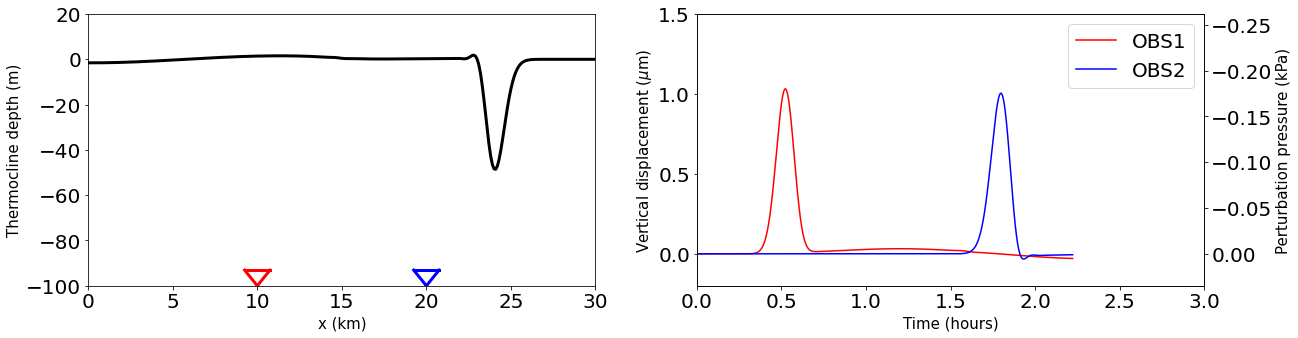

In [8]:
%%time 
# Animate
fig,(ax,ax2) = plt.subplots(1,2,figsize=(20,5))
ax22 = ax2.twinx()
matplotlib.rcParams.update({'font.size':20})
x1=10e3;x2=20e3
def update(i):
    if i%200==0:
        print(i,end=' ')
    ax.clear();ax2.clear();ax22.clear()
    ax.plot(eta.x/1000,eta[:,i],color='k',linewidth=3)
    ax2.plot(displacement.time[:i]/3600,displacement.sel(x=x1)[:i],color='r',label='OBS1')
    ax2.plot(displacement.time[:i]/3600,displacement.sel(x=x2)[:i],color='b',label='OBS2')
    plot_triangle(ax,x1/30e3,0,0.05,color='r')
    plot_triangle(ax,x2/30e3,0,0.05,color='b')
    
    ax.set_xlabel('x (km)')
    ax.set_ylabel('Thermocline depth (m)')
    ax.set_xlim(0,30)
    ax.set_ylim(-100,20)
    
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel(r'Vertical displacement ($\mu$m)')
    ax2.set_xlim(0,3)
    ax2.set_ylim(-0.2,1.5)
    fact = 1e-6/pressure_to_zeta(1,paramSeafloor)/1e3
    ax22.set_ylim(-0.2*fact,1.5*fact)
    ax22.set_ylabel('Perturbation pressure (kPa)')
    ax2.legend()

update(8000)

#create video
#dt=50
#im_ani = animation.FuncAnimation(fig, update, frames=np.arange(0,3*3600,dt),interval=dt*0.75)
#im_ani.save("1dwave.mp4")

## Inverting for the celerity profile 

In [9]:
def trapz_vector(x):
    """Given a grid x (supposed increasing), return the vector t of trapezoidal integration on that grid,
    i.e. for any vector of values f defined on x, the integral of f on x is np.dot(t,f)"""
    assert len(x) >=2
    return np.concatenate(([(x[1]-x[0])/2],(x[2:]-x[:-2])/2,[(x[-1]-x[-2])/2]))

def make_tomo_matrix(s_grid,obs_grid,x_initial):
    """Compute the matrix F that maps a profile of slowness to an array of arrival times.
    Args:
     - s_grid, array of x positions on which the slowness profile is inverted (units: m)
     - obs_grid, array of x positions at which wave arrival times are output (units: m)
     - x_initial, position of the wave trough at t=0
    Returns:
     - F, that maps an array of slownesses defined on s_grid (in s/m) to an array of arrival times (in s)
    """
    ns = len(s_grid)
    nobs = len(obs_grid)
    
    # Build vector of trapezoidal integration on s_grid
    trapzrule = trapz_vector(s_grid)
    trapzrule[0] += (s_grid[0]-x_initial) # Add component of integration between initial wave initial position and first element of s_grid
    
    F = np.zeros((nobs,ns))
    for i in range(nobs):
        # The arrival time at some position x is the integral of the slowness between x_initial and x
        # Line number i of F will thus contain the vector of integration between x_initial and obs_grid[i].
        F[i] = trapzrule*(s_grid<obs_grid[i])
        j = np.argmax(s_grid>=obs_grid[i]) 
        if j>0: # if obs_grid[i] is contained somewhere in the span of s_grid. Adjust the trapezoidal rule to integrate up to obs_grid[i] 
            alpha = obs_grid[i]-s_grid[j-1]
            dx = s_grid[j] - s_grid[j-1]
            F[i,j-1] += alpha*(1-alpha/2/dx) - dx/2
            F[i,j] = alpha**2/(2*dx)
        elif obs_grid[i]<=c_grid[0]:
            F[i,0] = obs_grid[i] - x_initial
        else: # in this case obs_grid[i]>c_grid[-1]
            F[i,-1]+=obs_grid[i]-c_grid[-1]
    return F

def tomo1D(arrival_times,F,reg,prior=2.67):
    """Estimate an array of velocities from the array of arrival times and the matrix F (that maps slownesses to arrival times)
    Args:
     - arrival_times, array arrival times on obs_grid (units: s)
     - F, matrix that maps slownesses on s_grid to arrival times on obs_grid 
     - reg, regularization parameter
     - prior, inital estimate of velocities (constant throughout the domain) in m/s
    Returns:
     - c, array of estimated velocities on s_grid (in m/s)
    """
    ns = F.shape[1]
    slownesses = spl.solve(np.dot(np.transpose(F),F)+reg*np.eye(ns),np.dot(np.transpose(F),arrival_times)+reg*1/prior*np.ones(ns))
    return 1/slownesses

With four observation stations

In [10]:
s_grid = wave.X[60:250:8]
obs_grid_4 = np.array([10100.,13500.,18100.,21000.])
F_4 = make_tomo_matrix(s_grid,obs_grid_4,x_initial)
arrival_times_obs_4 = np.array(arrival_times.sel(x=obs_grid_4))
celer_inverted_4 = tomo1D(arrival_times_obs_4,F_4,1e4,prior=2.67)
F_4.shape

(4, 24)

With nine observation stations

In [11]:
obs_grid_9 = np.array([10100.,11300.,12000.,13500.,15000.,16000.,17200.,18100.,21000.])
F_9 = make_tomo_matrix(s_grid,obs_grid_9,x_initial)
arrival_times_obs_9 = np.array(arrival_times.sel(x=obs_grid_9))
celer_inverted_9 = tomo1D(arrival_times_obs_9,F_9,1e4,prior=2.67)

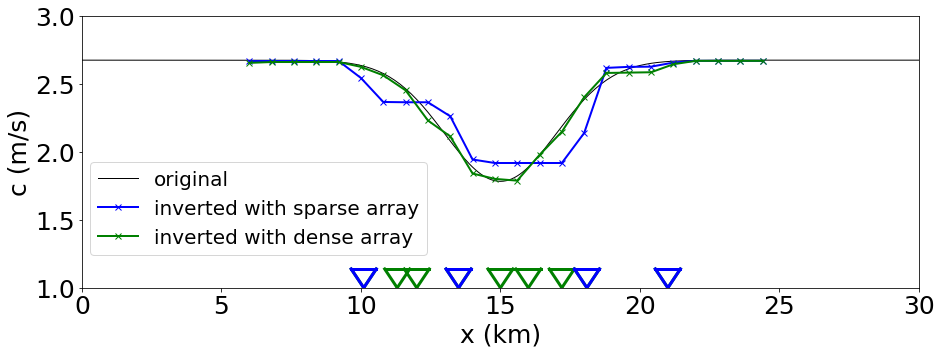

In [12]:
matplotlib.rcParams.update({'font.size':25})
_,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(wave.X/1000,wave.celer(wave.X),color='k',linewidth=1,label='original')

plt.plot(s_grid/1000,celer_inverted_4,'-xb',linewidth=2,label='inverted with sparse array')#,color='g')
plt.plot(s_grid/1000,celer_inverted_9,'-xg',linewidth=2,label='inverted with dense array')#,color='g')



ax.set_xlim(0,30)
ax.set_ylim(1,3)

ax.set_ylabel('c (m/s)')
ax.set_xlabel('x (km)')

for x in obs_grid_9:
    #plt.axvline(x,color='k')
    plot_triangle(plt.gca(),x/30e3,0,0.03,stretch=2,color='g')
for x in obs_grid_4:
    plot_triangle(plt.gca(),x/30e3,0,0.03,stretch=2,color='b')
ax.legend(fontsize=20,loc=(0.01,0.12))